Generated data shape: (16, 16, 16, 1000)


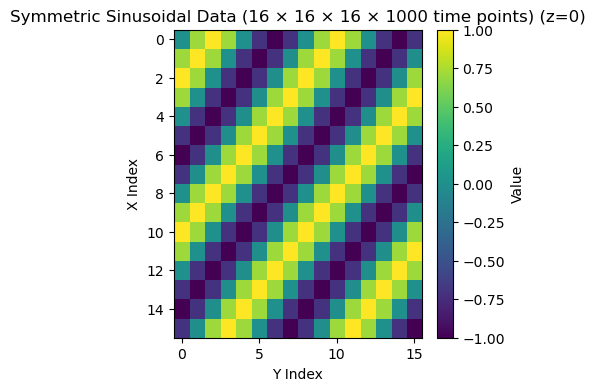

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from typing import Optional, Dict, Tuple
from dataclasses import dataclass

def generate_symmetric_sinusoidal_data(
    grid_size: int = 16, 
    time_points: int = 1000, 
    cycles: float = 4.0
) -> np.ndarray:
    """
    Generate symmetric sinusoidal data using vectorized operations.
    
    Args:
        grid_size: Size of the cube grid (default: 16x16x16)
        time_points: Number of time points (default: 1000)
        cycles: Number of full cycles over time (default: 4.0)
        
    Returns:
        np.ndarray: Symmetric data of shape (grid_size, grid_size, grid_size, time_points)
    """
    t = np.linspace(0, cycles * np.pi, time_points)
    
    # Create coordinate grids for vectorized computation
    i_grid, j_grid, k_grid = np.meshgrid(np.arange(8), np.arange(8), np.arange(8), indexing='ij')
    
    # Compute phase shifts vectorized
    phase_i = i_grid * np.pi / 4
    phase_j = j_grid * np.pi / 4
    phase_k = k_grid * np.pi / 8
    
    # Compute amplitudes and frequencies vectorized
    amplitude = 1.0 + 0.5 * np.sin(i_grid * np.pi / 8) * np.cos(j_grid * np.pi / 8) * np.sin(k_grid * np.pi / 8)
    frequency = 1.0 + 0.2 * (i_grid + j_grid + k_grid) / 24
    
    # Broadcast for time dimension and compute sinusoidal patterns
    phase_total = phase_i[..., np.newaxis] + phase_j[..., np.newaxis] + phase_k[..., np.newaxis]
    frequency_broadcast = frequency[..., np.newaxis]
    amplitude_broadcast = amplitude[..., np.newaxis]
    
    sin_patterns = amplitude_broadcast * np.sin(frequency_broadcast * t + phase_total)
    
    # Initialize full data array
    data = np.zeros((grid_size, grid_size, grid_size, time_points))
    
    # Fill symmetric positions using advanced indexing
    data[:8, :8, :8, :] = sin_patterns  # Upper left front
    data[:8, :8, 8:, :] = sin_patterns  # Upper left back (mirror along z)
    data[:8, 8:, :8, :] = sin_patterns  # Upper right front (mirror along y)
    data[:8, 8:, 8:, :] = sin_patterns  # Upper right back (mirror along y and z)
    data[8:, :8, :8, :] = sin_patterns  # Lower left front (mirror along x)
    data[8:, :8, 8:, :] = sin_patterns  # Lower left back (mirror along x and z)
    data[8:, 8:, :8, :] = sin_patterns  # Lower right front (mirror along x and y)
    data[8:, 8:, 8:, :] = sin_patterns  # Lower right back (mirror along all axes)
    
    return data

# Generate the data
data = generate_symmetric_sinusoidal_data()
print(f"Generated data shape: {data.shape}")

def plot_3d_volume(data: np.ndarray, time_index: int = 0, title: str = "3D Volume Visualization") -> None:
    """Create an interactive 3D volume visualization using plotly."""
    # Extract data at specific time point
    volume_data = data[:, :, :, time_index]
    
    # Create coordinate grids
    x, y, z = np.meshgrid(np.arange(data.shape[0]), 
                          np.arange(data.shape[1]), 
                          np.arange(data.shape[2]), indexing='ij')
    
    # Flatten arrays for scatter plot
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()
    values_flat = volume_data.flatten()
    
    # Create 3D scatter plot with color mapping
    fig = go.Figure(data=go.Scatter3d(
        x=x_flat,
        y=y_flat,
        z=z_flat,
        mode='markers',
        marker=dict(
            size=3,
            color=values_flat,
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(title="Value")
        ),
        text=[f'({x},{y},{z}): {val:.3f}' for x,y,z,val in zip(x_flat, y_flat, z_flat, values_flat)],
        hovertemplate='<b>Position:</b> (%{x}, %{y}, %{z})<br><b>Value:</b> %{marker.color:.3f}<extra></extra>'
    ))
    
    fig.update_layout(
        title=f'{title} (t={time_index})',
        scene=dict(
            xaxis_title='X Index',
            yaxis_title='Y Index',
            zaxis_title='Z Index',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
        ),
        width=800,
        height=600
    )
    
    fig.show()

def plot_3d_isosurface(data: np.ndarray, time_index: int = 0, isomin: float = None, isomax: float = None) -> None:
    """Create a 3D isosurface visualization using plotly."""
    volume_data = data[:, :, :, time_index]
    
    if isomin is None:
        isomin = np.percentile(volume_data, 20)
    if isomax is None:
        isomax = np.percentile(volume_data, 80)
    
    fig = go.Figure(data=go.Isosurface(
        x=np.arange(data.shape[0]).repeat(data.shape[1] * data.shape[2]),
        y=np.tile(np.arange(data.shape[1]).repeat(data.shape[2]), data.shape[0]),
        z=np.tile(np.arange(data.shape[2]), data.shape[0] * data.shape[1]),
        value=volume_data.flatten(),
        isomin=isomin,
        isomax=isomax,
        surface_count=5,
        colorscale='Viridis',
        caps=dict(x_show=False, y_show=False, z_show=False)
    ))
    
    fig.update_layout(
        title=f'3D Isosurface Visualization (t={time_index})',
        scene=dict(
            xaxis_title='X Index',
            yaxis_title='Y Index', 
            zaxis_title='Z Index'
        ),
        width=800,
        height=600
    )
    
    fig.show()

def plot_data_snapshot(data: np.ndarray, time_index: int = 0, z_slice: int = 0, title: str = "Data Snapshot") -> None:
    """Plot a snapshot of the data at a specific time index and z-slice."""
    plt.figure(figsize=(4, 4))
    plt.imshow(data[:, :, z_slice, time_index], aspect='auto', cmap='viridis')
    plt.colorbar(label='Value')
    plt.xlabel('Y Index')
    plt.ylabel('X Index')
    plt.title(f'{title} (z={z_slice})')
    plt.show()

# Create visualizations
plot_data_snapshot(data, title='Symmetric Sinusoidal Data (16 × 16 × 16 × 1000 time points)')
plot_3d_volume(data, time_index=0, title='3D Volume Visualization')
plot_3d_isosurface(data, time_index=0)


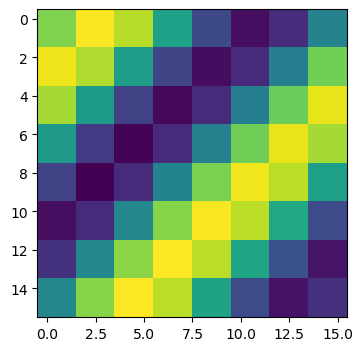

In [3]:
# data: (16, 16, T)
# _WEIGHT_MATRIX_SYMMETRY: (18, 18) with F = 1/3 as you defined
F=1/3
_WEIGHT_MATRIX_SYMMETRY = np.array([
    [F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F],
    [F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, F, F, 0, 0, F, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, F, 0, 0, F, F, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F],
    [F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F]
], dtype=np.float32)

W = _WEIGHT_MATRIX_SYMMETRY.astype(np.float32)

# Build the 16×18 selector C that drops the padded slots (rows/cols 8 and 9).
# C picks indices [0..7, 10..17] from an 18-long axis.
C = np.zeros((16, 18), dtype=W.dtype)
C[np.arange(8), np.arange(8)] = 1
C[np.arange(8, 16), np.arange(10, 18)] = 1

# Precompute the effective 16×16 transforms:
# For each time slice A (16×16), the padded+two-sided transform equals:
#   A_out = C @ (W.T @ (C.T @ A @ C) @ W) @ C.T
# which simplifies to:
#   A_out = (C @ W.T @ C.T) @ A @ (C @ W @ C.T)
L = C @ W.T @ C.T   # (16, 16)
R = C @ W    @ C.T  # (16, 16)
Z = C @ W @ C.T  # (16, 16)
# Single batched contraction: out[a,b,t] = sum_i,j L[a,i] * data[i,j,t] * R[j,b]
out = np.einsum('ai,ijkt,jb,kc->abct', L, data, R, Z, optimize=True)  # (16, 16, 16, T)

# quick peek
plt.figure(figsize=(4, 4))
plt.imshow(out[:, :, 0, 0], aspect='auto', cmap='viridis')
plt.show()
plot_3d_volume(data, time_index=0)
plot_3d_volume(out, time_index=0)

Data shape after padding: (18, 18, 16, 1000)


TypeError: Invalid shape (18, 18, 1000) for image data

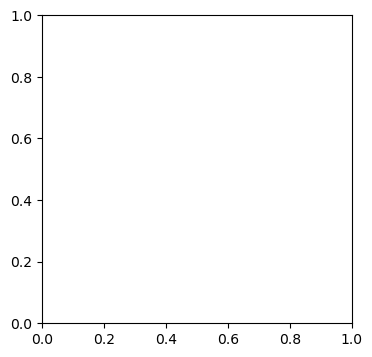

In [4]:
# Convert data from EIP to EB coordinates
# First, add padding at indices 8 and 9 to match EIP format (18 channels)
plt.figure(figsize=(4, 4))
data = np.insert(data, [8, 8], 0, axis=0)  # Insert zeros at rows 8 and 9
data = np.insert(data, [8, 8], 0, axis=1)  # Insert zeros at columns 8 and 9
print(f"Data shape after padding: {data.shape}")
plt.imshow(data[:, :, 0], aspect='auto', cmap='viridis')

# Define EIP to EB transformation (using pre-computed weight matrix for efficiency)
F = 1/3
_WEIGHT_MATRIX_SYMMETRY = np.array([
    [F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F],
    [F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, F, F, 0, 0, F, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, F, 0, 0, F, F, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F],
    [F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F]
], dtype=np.float32)

def eip_to_eb_fast(eip: np.ndarray) -> np.ndarray:
    """Optimized EIP to EB transformation using pre-computed matrix multiplication."""
    eb = eip@_WEIGHT_MATRIX_SYMMETRY
    return eb

# Apply EIP to EB transformation across all dimensions
# Transform along time axis (columns)
for j in range(data.shape[1]):
    eb_result = eip_to_eb_fast(data[:, j, :].T).T
    data[:, j, :] = eb_result

plt.figure(figsize=(4, 4))
plt.imshow(data[:, :, 0], aspect='auto', cmap='viridis')

# Transform along spatial axis (rows)
for i in range(data.shape[0]):
    eb_result = eip_to_eb_fast(data[i, :, :].T).T
    # eb_result = np.insert(eb_result, [8, 8], 0, axis=0)  # Add padding back
    data[i, :, :] = eb_result

plt.figure(figsize=(4, 4))
plt.imshow(data[:, :, 0], aspect='auto', cmap='viridis')

# Remove padding to get final EB coordinates (16x16)
data = np.delete(data, [8, 9], axis=0)  # Remove padded rows
data = np.delete(data, [8, 9], axis=1)  # Remove padded columns

plt.figure(figsize=(4, 4))
plt.imshow(data[:, :, 0], aspect='auto', cmap='viridis')
print(f"Final data shape after EIP to EB conversion: {data.shape}")


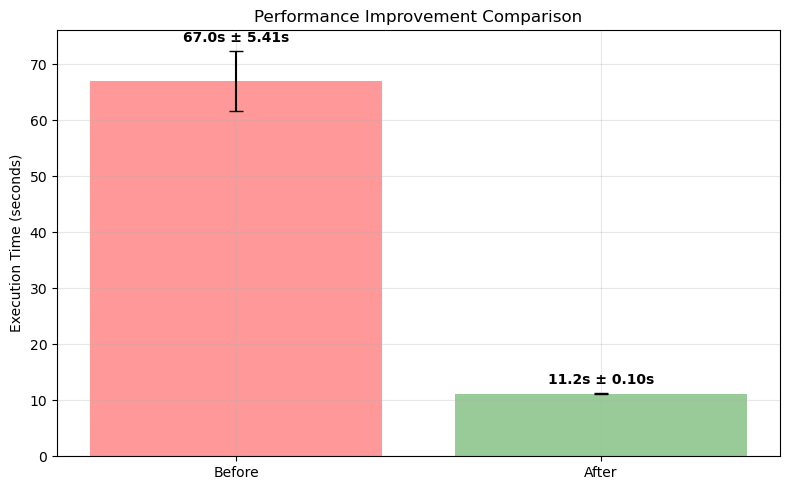

Performance improvement summary:
- Before: 67.0s ± 5.41s
- After: 11.2s ± 0.104s
- Speed improvement: 6.0x
- Time saved: 83.3%


In [ ]:
# Performance improvement comparison chart
import matplotlib.pyplot as plt
import numpy as np

# Performance data
methods = ['Before', 'After']
times = [67.0, 11.2]  # in seconds
std_devs = [5.41, 0.104]

# Create bar chart
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))

# Bar chart - execution time comparison
bars = ax1.bar(methods, times, yerr=std_devs, capsize=5, 
               color=['#ff7f7f', '#7fbf7f'], alpha=0.8)
ax1.set_ylabel('Execution Time (seconds)')
ax1.set_title('Performance Improvement Comparison')
ax1.grid(True, alpha=0.3)

# Display values on top of bars
for i, (bar, time, std) in enumerate(zip(bars, times, std_devs)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 1,
             f'{time:.1f}s ± {std:.2f}s',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

improvement_factor = times[0] / times[1]
print(f"Performance improvement summary:")
print(f"- Before: {times[0]:.1f}s ± {std_devs[0]:.2f}s")
print(f"- After: {times[1]:.1f}s ± {std_devs[1]:.3f}s")
print(f"- Speed improvement: {improvement_factor:.1f}x")
print(f"- Time saved: {((times[0]-times[1])/times[0]*100):.1f}%")